In [26]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from IPython.display import Image, display

print(tf.__version__)

2.0.0-alpha0


# Inspect Data


In [27]:
train_csv = pd.read_csv('kaggle/train.csv')
print(train_csv.describe())
print(train_csv.head())

         has_cactus
count  17500.000000
mean       0.750629
std        0.432662
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000
                                     id  has_cactus
0  0004be2cfeaba1c0361d39e2b000257b.jpg           1
1  000c8a36845c0208e833c79c1bffedd1.jpg           1
2  000d1e9a533f62e55c289303b072733d.jpg           1
3  0011485b40695e9138e92d0b3fb55128.jpg           1
4  0014d7a11e90b62848904c1418fc8cf2.jpg           1


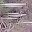

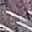

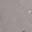

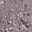

In [28]:
# Cactus
display(Image('kaggle/train/0004be2cfeaba1c0361d39e2b000257b.jpg'))
display(Image('kaggle/train/000c8a36845c0208e833c79c1bffedd1.jpg'))

# No cactus
display(Image('kaggle/train/ffede47a74e47a5930f81c0b6896479e.jpg'))
display(Image('kaggle/train/fff43acb3b7a23edcc4ae937be2b7522.jpg'))

In [29]:
filenames = ['kaggle/train/' + fname for fname in train_csv['id'].tolist()]
labels = train_csv['has_cactus'].tolist()


train_filenames, val_filenames, train_labels, val_labels = train_test_split(filenames,
                                                                            labels,
                                                                            train_size=0.9,
                                                                            random_state=420)

num_train = len(train_filenames)
num_val = len(val_filenames)


In [30]:
IMAGE_SIZE = 96


def _parse_fn(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_normalized = (tf.cast(image_decoded, tf.float32)/127.5) - 1
  image_resized = tf.image.resize(image_normalized, (IMAGE_SIZE, IMAGE_SIZE))
  return image_resized, label

In [31]:
BATCH_SIZE = 32

train_data = tf.data.Dataset.from_tensor_slices((tf.constant(train_filenames), 
                                                 tf.constant(train_labels))).map(_parse_fn).shuffle(buffer_size=10000).batch(BATCH_SIZE)


val_data = tf.data.Dataset.from_tensor_slices((tf.constant(val_filenames), 
                                               tf.constant(val_labels))).map(_parse_fn).batch(BATCH_SIZE)

# Define model

In [32]:
# Base model with MobileNetV2
IMG_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False, 
                                               weights='imagenet')
base_model.trainable = False

In [33]:
# Trainable classification head
maxpool_layer = tf.keras.layers.GlobalMaxPooling2D()
prediction_layer = tf.keras.layers.Dense(1, activation='sigmoid')

In [34]:
learning_rate = 0.0001

model = tf.keras.Sequential([
    base_model,
    maxpool_layer,
    prediction_layer
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Train

In [35]:
num_epochs = 30
steps_per_epoch = round(num_train)//BATCH_SIZE
val_steps = 20

In [36]:
history = model.fit(train_data.repeat(),
                    epochs=num_epochs,
                    steps_per_epoch = steps_per_epoch,
                    validation_data=val_data.repeat(), 
                    validation_steps=val_steps)

Epoch 1/30
492/492 [==============================] - 474s 963ms/step - loss: 0.4245 - accuracy: 0.8255 - val_loss: 0.4274 - val_accuracy: 0.7953
Epoch 2/30
492/492 [==============================] - 320s 650ms/step - loss: 0.1904 - accuracy: 0.9235 - val_loss: 0.4045 - val_accuracy: 0.8172
Epoch 3/30
492/492 [==============================] - 318s 647ms/step - loss: 0.1536 - accuracy: 0.9376 - val_loss: 0.3253 - val_accuracy: 0.8641
Epoch 4/30
492/492 [==============================] - 301s 612ms/step - loss: 0.1341 - accuracy: 0.9482 - val_loss: 0.2915 - val_accuracy: 0.8625
Epoch 5/30
492/492 [==============================] - 301s 612ms/step - loss: 0.1251 - accuracy: 0.9506 - val_loss: 0.2221 - val_accuracy: 0.9203
Epoch 6/30
492/492 [==============================] - 301s 612ms/step - loss: 0.1154 - accuracy: 0.9555 - val_loss: 0.2182 - val_accuracy: 0.9125
Epoch 7/30
492/492 [==============================] - 298s 607ms/step - loss: 0.1078 - accuracy: 0.9571 - val_loss: 0.2177 -

In [37]:
# Save model weights
model.save_weights('weights_epoch_30.h5')

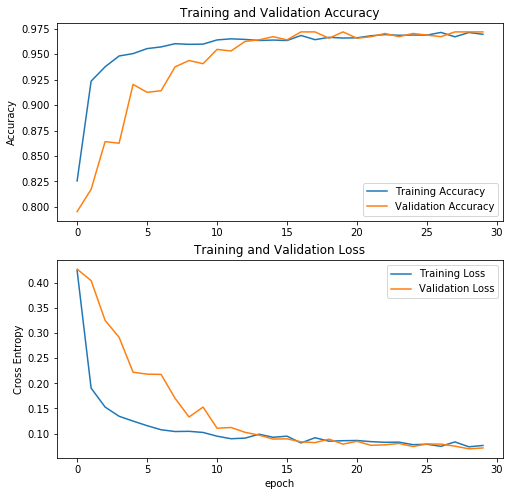

In [38]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Fine tune

In [39]:
# Unfreeze all layers of MobileNetV2
base_model.trainable = True

# Refreeze layers until the layers we want to fine-tune
for layer in base_model.layers[:100]:
  layer.trainable =  False

In [40]:
model.compile(loss='binary_crossentropy',
              optimizer = tf.keras.optimizers.Adam(lr=learning_rate/10),
              metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_96 (Model)  (None, 3, 3, 1280)        2257984   
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [41]:
fine_tune_epochs = 30
total_epochs =  num_epochs + fine_tune_epochs

history_fine = model.fit(train_data.repeat(), 
                         steps_per_epoch = steps_per_epoch,
                         epochs=total_epochs, 
                         initial_epoch = num_epochs,
                         validation_data=val_data.repeat(), 
                         validation_steps=val_steps)

Epoch 31/60
492/492 [==============================] - 406s 826ms/step - loss: 0.0687 - accuracy: 0.9730 - val_loss: 0.0475 - val_accuracy: 0.9812
Epoch 32/60
492/492 [==============================] - 383s 778ms/step - loss: 0.0488 - accuracy: 0.9824 - val_loss: 0.0341 - val_accuracy: 0.9891
Epoch 33/60
492/492 [==============================] - 388s 788ms/step - loss: 0.0364 - accuracy: 0.9861 - val_loss: 0.0305 - val_accuracy: 0.9906
Epoch 34/60
492/492 [==============================] - 390s 792ms/step - loss: 0.0299 - accuracy: 0.9888 - val_loss: 0.0264 - val_accuracy: 0.9906
Epoch 35/60
492/492 [==============================] - 392s 796ms/step - loss: 0.0230 - accuracy: 0.9920 - val_loss: 0.0234 - val_accuracy: 0.9906
Epoch 36/60
492/492 [==============================] - 391s 794ms/step - loss: 0.0207 - accuracy: 0.9929 - val_loss: 0.0204 - val_accuracy: 0.9906
Epoch 37/60
492/492 [==============================] - 390s 794ms/step - loss: 0.0131 - accuracy: 0.9961 - val_loss: 0

In [42]:
# Save fine-tuned model weights
model.save_weights('weights_epoch_50_finetuned.h5')

In [43]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

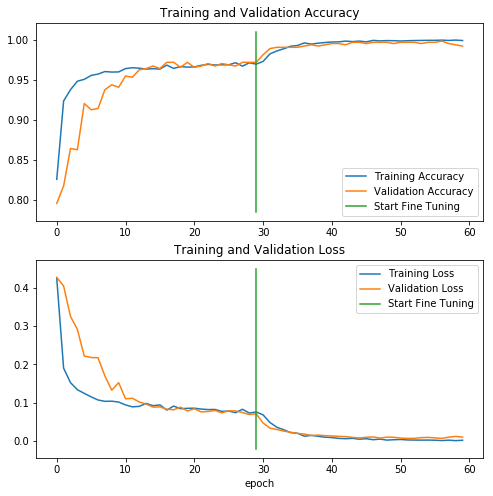

In [44]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.plot([num_epochs-1,num_epochs-1], 
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([num_epochs-1,num_epochs-1], 
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()